## Analiza danych rzeczywistych przy pomocy modelu ARMA

### Spis treści:
1. Wstęp
    - Cel pracy
    - Informacja o danych oraz wizualizacja danych
2. Przygotowanie danych do analizy
    - zbadanie jakości danych
    - dekompozycja szeregu czasowego
3. Modelowanie danych przy pomocy ARMA
    - dobranie rzędu modeli na podstawie kryterium AIC
    - estymacja parametrów
4. Ocena dopasowania modelu
    - przedziały ufności dla PACF
    - prognoza dla przyszłych obserwacji i porównanie z rzeczywistymi danymi
5. Weryfikacja założeń dotyczących szumu
    - założenie dot. średniej
    - założenie dot. wariancji 
    - założenie dot. niezależności 
    - założenie dot. normalności rozkładu
6. Wnioski

### 1. Wstęp

#### Cel pracy

Niniejszy raport skupia się na zastosowaniu modelu ARMA do modelowania temperatury powietrza na wyspie Jan Mayen za ostatnie 10 lat. Celem analizy jest nie tylko identyfikacja wzorców i potencjalnych anomalii, ale także próba przewidzenia przyszłych trendów, które mogą mieć znaczący wpływ na gospodarkę, ekosystemy i życie codzienne społeczności lokalnych.


#### Informacja o danych oraz wizualizacja danych
Dane są pobrane ze strony https://www.ncei.noaa.gov/ (NCEI - National Centers for Environmental Information). 
 
> NCEI provides environmental data, products, and services covering the depths of the ocean to the surface of the sun to drive resilience, prosperity, and equity for current and future generations.

Dane dotyczą dziennej temperatury powietrza na wyspie Jan Mayen. Jan Mayen to wyspa wulkaniczna w Arktyce, ok. 500 km na wschód od Grenlandii, oblewają ją wody Oceanu Arktycznego: Morze Grenlandzkie od północy, Cieśnina Duńska od zachodu i Morze Norweskie od południa i wschodu. Od 1930 r. administracyjnie przynależy do Norwegii. 

Probka zawiera dane za ostatnie 10 lat plus 23 dni stycznia 2024 roku.

Poniżej jest przedstawiony wykres danych, możemy zobaczyć wyrażną sezonowość:

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#import pmdarima as pm

In [217]:
df = pd.read_csv("dane_Jan_Mayen.csv")
temperatura = df['TEMP']

df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)
print(pd.date_range(
  start="2014-01-01", end="2024-01-23").difference(df.index))

DatetimeIndex(['2014-12-17', '2015-03-01', '2015-03-02', '2018-09-17',
               '2020-10-29', '2021-01-21', '2021-02-11', '2021-02-12',
               '2023-06-25'],
              dtype='datetime64[ns]', freq=None)


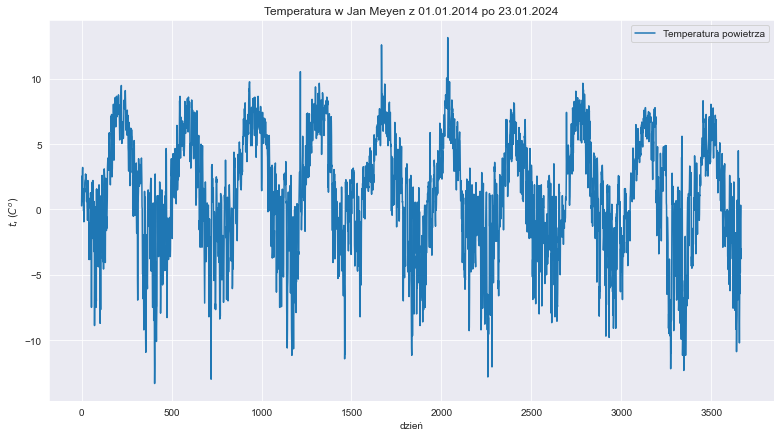

In [218]:
plt.figure(figsize=[13,7])
plt.plot(temperatura, label="Temperatura powietrza")
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.title("Temperatura w Jan Meyen z 01.01.2014 po 23.01.2024")
plt.legend()
plt.grid(True)
plt.show()

### 2. Przygotowanie danych do analizy

#### Zbadanie jakości danyh

W próbce jest 9 braków danych w dniach '2014-12-17', '2015-03-01', '2015-03-02', '2018-09-17', '2020-10-29', '2021-01-21', '2021-02-11', '2021-02-12', '2023-06-25'. Odnośnie 3666 wartości to nie dużo, więc nie będzie miało dużego wpływu na modelowanie. 

W danych nie ma odstających wartości. Liczyłam wartości za odstające jeżeli były z poza przedziału ${\displaystyle [(x_{25}-1{,}5\cdot (x_{75}-x_{25})),\,\,(x_{75}+1{,}5\cdot (x_{75}-x_{25}))]}$, gdzie $x_{75}$ oraz $x_{25}$ to kwantyli rzędów $0.75, 0.25$ odpowiednio.

Też wyodrębniłam dane testowe. Zbior testowy bedzie składać się z wartości temperatury za styczeń 2024 roku.

#### Dekompozycja szeregu czasowego

##### Wykres ACF oraz PACF

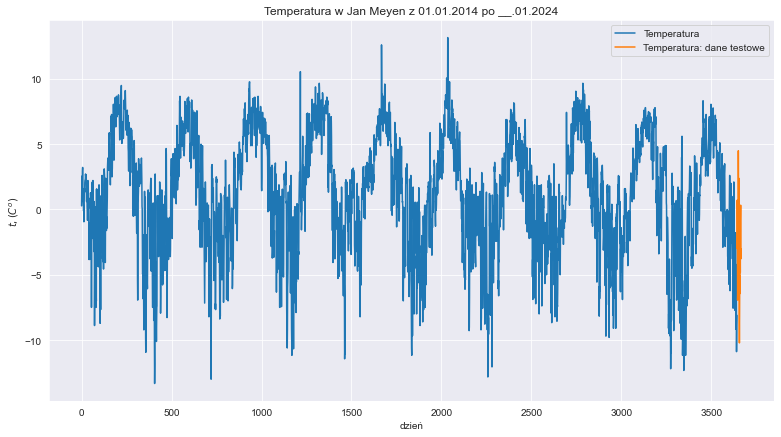

In [219]:
temperatura_test = temperatura[3643:]
temperatura = temperatura[:3643]
plt.figure(figsize=[13,7])
plt.plot(temperatura, label="Temperatura")
plt.plot(temperatura_test, label="Temperatura: dane testowe")
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.title("Temperatura w Jan Meyen z 01.01.2014 po __.01.2024")
plt.legend()
plt.grid(True)
plt.show()

#### Dekompozycja szeregu czasowego

##### Wykres ACF oraz PACF

In [220]:
count = 0
q25 = np.quantile(temperatura, 0.25)
q75 = np.quantile(temperatura, 0.75)

for i in temperatura:
    
    if i < q25 - 1.5*(q75 - q25) and i > q25 + 1.5*(q75 - q25):
        count += 1

In [221]:
temperatura_test = temperatura[3643:]
temperatura = temperatura[:3643]

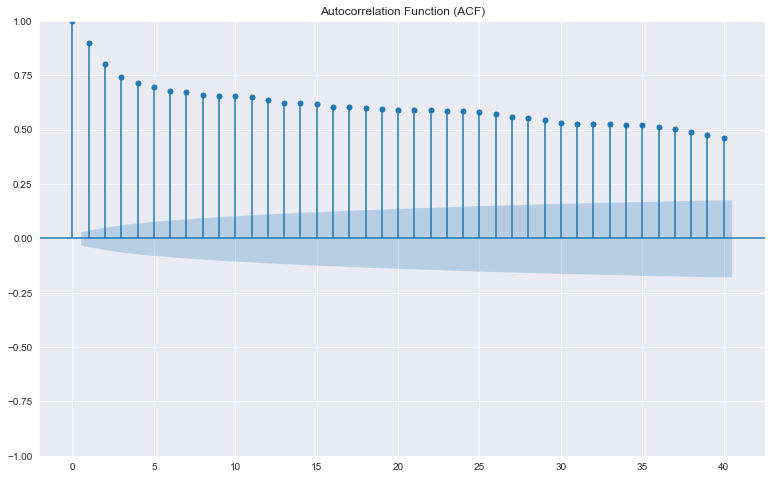

In [222]:

# Wykres ACF
fig, ax = plt.subplots(figsize=(13, 8))
sm.graphics.tsa.plot_acf(temperatura, ax, lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()


Wartości ACF stopniowo maleją, co może wskazywać na to, że szereg czasowy wykazuje pewien trend lub efekt autoregresyjny. Wartości są dodatnie i powoli spadają z każdym kolejnym opóźnieniem, co może sugerować, że proces ma naturę autoregresyjną. Brak gwałtownego spadku do zera po pierwszych kilku opóźnieniach sugeruje, że model ARMA może być bardziej odpowiedni niż czysty model AR lub MA. Wszystkie wartości ACF mieszczą się wewnątrz pasm ufności, co może wskazywać, że nie ma silnej autokorelacji w żadnym konkretnym opóźnieniu. 

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


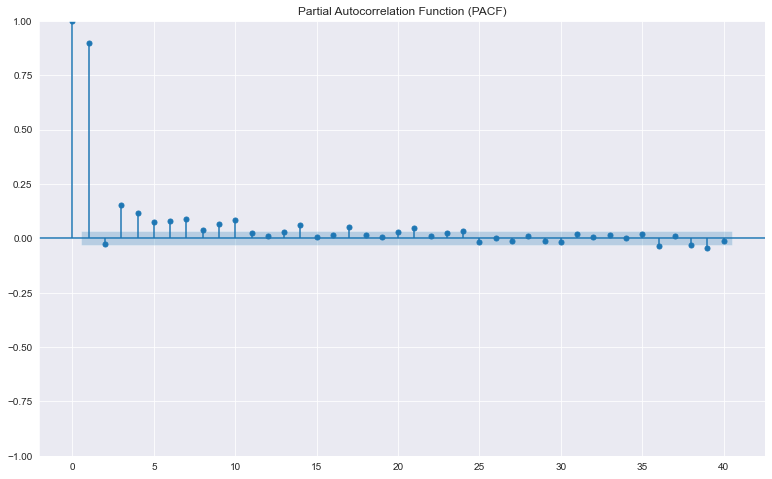

In [223]:
# Wykres PACF
fig, ax = plt.subplots(figsize=(13, 8))
sm.graphics.tsa.plot_pacf(temperatura, ax, lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Pierwsze opóźnienie jest znaczące i wysokie, co wskazuje na silną autokorelację częściową w pierwszym opóźnieniu. Wartości PACF dla pozostałych opóźnień szybko spadają niemal do zera i oscylują wokół niego, pozostając wewnątrz pasm ufności. Oznacza to, że nie ma już dodatkowej autokorelacji częściowej po uwzględnieniu pierwszego opóźnienia.


#### Dickey - Fuller test:

In [224]:

adf_test = sm.tsa.stattools.adfuller(temperatura)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Dodatkowo wypiszemy liczbę użytych opóźnień
print('Number of lags used: %d' % adf_test[2])
# oraz liczbę obserwacji
print('Number of observations: %d' % adf_test[3])


ADF Statistic: -3.896228
p-value: 0.002063
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Number of lags used: 23
Number of observations: 3619


Statystyka testowa wynosi $-3.896228$, jest mniejsza niż wartości krytyczne, jakie wynoszą $ -3.432, -2.862, -2.567 $ dla $\alpha = \{0.01,0.05,0.1\}$, sugeruje to, że szereg czasowy jest stacjonarny.
P-wartość wynosi $0.002063$ jest mniejsza niż $0.05$, sugeruje to, że szereg czasowy jest stacjonarny z poziomem ufności 95%.

##### Identyfikacja trendów deterministycznych

Usunięcie trendu:

Narysujemy linię trendu

In [225]:
'''from statsmodels.tsa.seasonal import seasonal_decompose, STL
decomposition = seasonal_decompose(temperatura, model='additive', period=30, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(temperatura, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()'''

"from statsmodels.tsa.seasonal import seasonal_decompose, STL\ndecomposition = seasonal_decompose(temperatura, model='additive', period=30, extrapolate_trend=1)\n\ntrend = decomposition.trend\nseasonal = decomposition.seasonal\nresidual = decomposition.resid\n\nplt.figure(figsize=(10, 5))\n\nplt.subplot(2, 2, 1)\nplt.plot(temperatura, label='Original')\nplt.title('Surowe dane')\n\nplt.subplot(2, 2, 2)\nplt.plot(trend, label='Trend', color='red')\nplt.title('Trend')\n\nplt.subplot(2, 2, 3)\nplt.plot(seasonal, label='Seasonal', color='green')\nplt.title('Sezonowość')\n\nplt.subplot(2, 2, 4)\nplt.plot(residual, label='Residual', color='orange')\nplt.title('Dane po usunięciu trendu i sezonowości')\n\nplt.tight_layout()\nplt.show()"

In [237]:
'''fig, ax = plt.subplots(figsize=(13, 8))
sm.graphics.tsa.plot_acf(residual,ax)
plt.title('Autocorrelation Function (ACF)')'''

"fig, ax = plt.subplots(figsize=(13, 8))\nsm.graphics.tsa.plot_acf(residual,ax)\nplt.title('Autocorrelation Function (ACF)')"

(1.7446344643035248, -0.0002676363150708927)

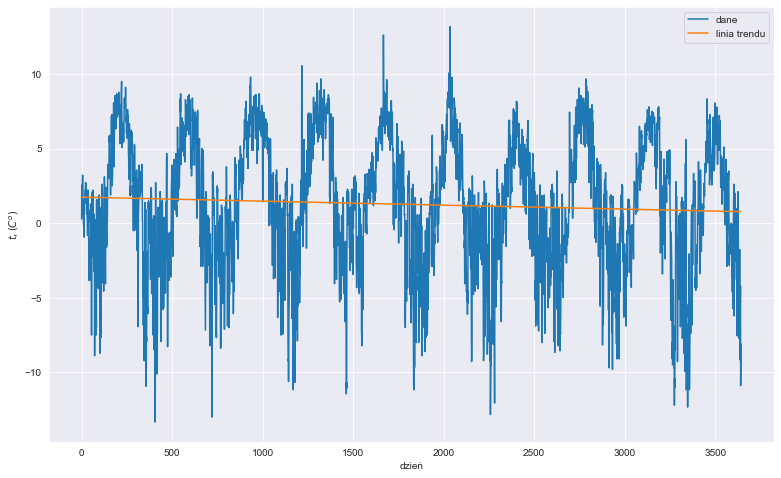

In [238]:
def reglin(X, Y):
    X_mean = np.array(X).mean()
    Y_mean = np.array(Y).mean()

    sum1 = 0
    sum2 = 0

    for i in range(len(X)):
        sum1 += X[i] * (Y[i] - Y_mean)
        sum2 += (X[i] - X_mean) ** 2

    beta1 = sum1 / sum2
    beta0 = Y_mean - beta1 * X_mean
    return [beta1, beta0]

beta1, beta0 = reglin(np.arange(0,len(temperatura),1), temperatura)

plt.figure(figsize=[13,8])
plt.plot(np.arange(0,len(temperatura),1), temperatura, label = 'dane')
plt.plot([0,3640], [beta0, beta0 + beta1 *3640], label = 'linia trendu')
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.legend()
plt.grid(True)

beta0, beta1


Do usunęcia trendu skorzystałam z regresji liniowej: dobrałam parametry $\beta_0$ oraz $\beta_1$ do równania $y = \beta_0 +\beta_1 x$. Linia trendu ma równanie $y = -0.000268x + 1.745$. Po usunięciu trendu wykres troche przeniósł się do dołu.

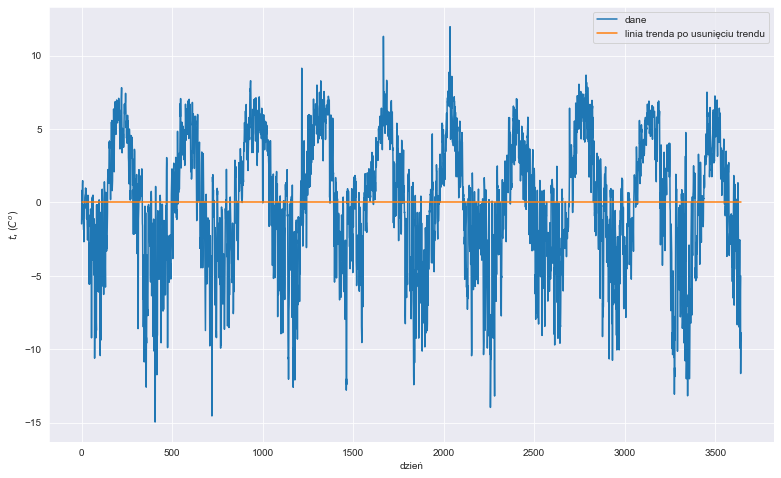

In [228]:

temp_detrened= temperatura - beta0 - beta1 * np.arange(0,len(temperatura),1)
plt.figure(figsize=[13,8])
plt.plot(np.arange(0,len(temperatura),1), temp_detrened, label = 'dane')
beta1, beta0 = reglin(np.arange(0,len(temperatura),1), temp_detrened)
plt.plot([0,3640], [beta0, beta0 + beta1 *3640], label = 'linia trenda po usunięciu trendu')
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.legend()
plt.grid(True)

Narysujemy sezonowość:

(array([-4.54368945,  0.01761337]), array([[5.23698786e-03, 6.47823958e-09],
       [6.47823958e-09, 5.65394018e-11]]))


(array([-4.54368945,  0.01761337]),
 array([[5.23698786e-03, 6.47823958e-09],
        [6.47823958e-09, 5.65394018e-11]]))

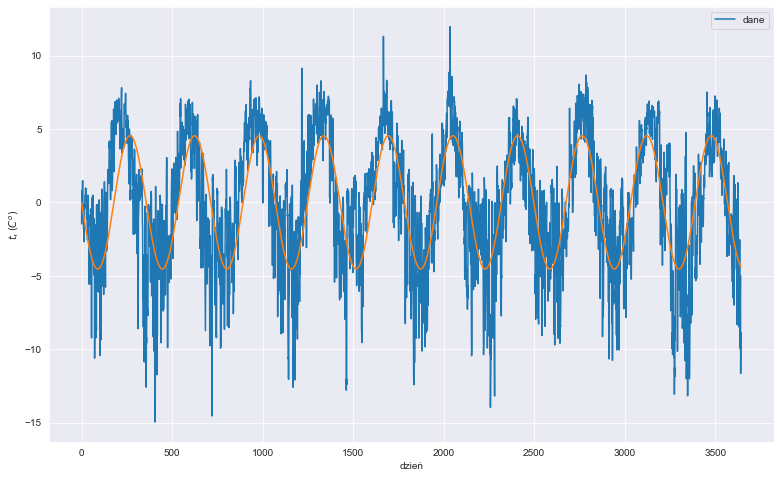

In [229]:
from scipy import stats, optimize
def my_fun(X, param1, param2):
    return param1 * np.sin(param2 * X)

params = optimize.curve_fit(my_fun, np.arange(0,len(temperatura),1), temp_detrened, p0=[-4,2*np.pi/365.5])
print(params)
plt.figure(figsize=[13,8])
plt.plot(np.arange(0,len(temperatura),1), temp_detrened, label = 'dane')
plt.plot(np.arange(0,len(temperatura),1), params[0][0] * np.sin(params[0][1] * np.arange(0,len(temperatura),1)))
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.legend()
plt.grid(True)
temp_deseasoned = temp_detrened - params[0][0] * np.sin(params[0][1] * np.arange(0,len(temperatura),1))
params


Dobrałam paramytry do równania $y = a \sin(b*x)$ za pomocą funkcji optimize.curve_fit() z biblioteki *scipy*. Linia sezonowości ma równanie $y = -4.54 \sin(0.0176x)$. Wykres po usunięciu sezonowości:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


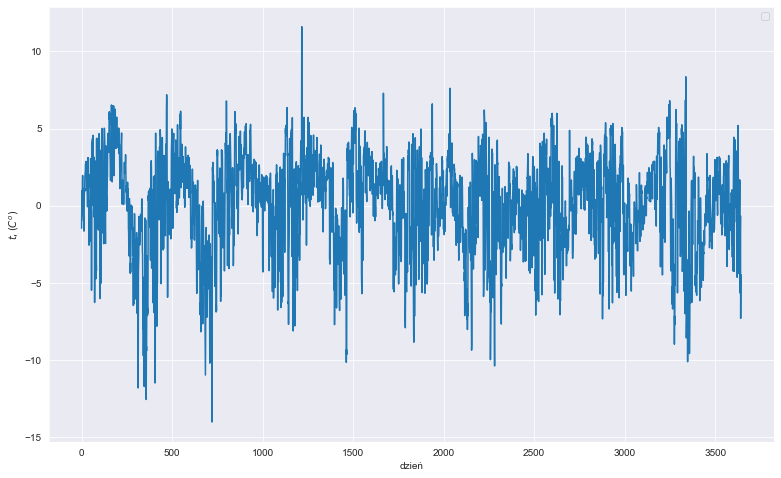

In [230]:
plt.figure(figsize=[13,8])
plt.plot(np.arange(0,len(temperatura),1), temp_deseasoned)
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.legend()
plt.grid(True)

In [231]:
from scipy.stats import boxcox

# Zastosuj transformację Boxa-Coxa
temp_deseasoned, lam = boxcox(abs(temp_deseasoned))

##### Wykres ACF oraz PACF dla uzyskanego szeregu:

Skorzystałam jeszcze z transformacji stabilizującej warjancje, żeby o ile to możliwe zmniejszyć stacjonarność. 
Poniżej jest wykres ACF uzyskanego szeregu, widzimy że on geometrycznie zanika.

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

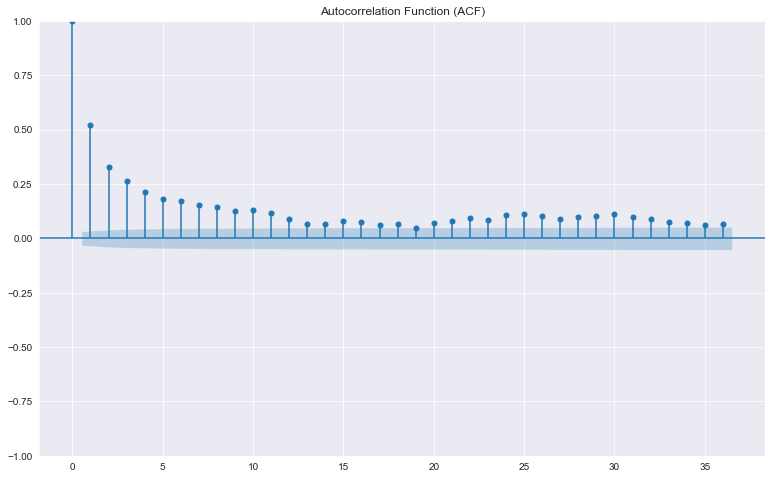

In [232]:
fig, ax = plt.subplots(figsize=(13, 8))
sm.graphics.tsa.plot_acf(temp_deseasoned,ax)
plt.title('Autocorrelation Function (ACF)')

Wykres PACF uzyskanego szeregu:

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

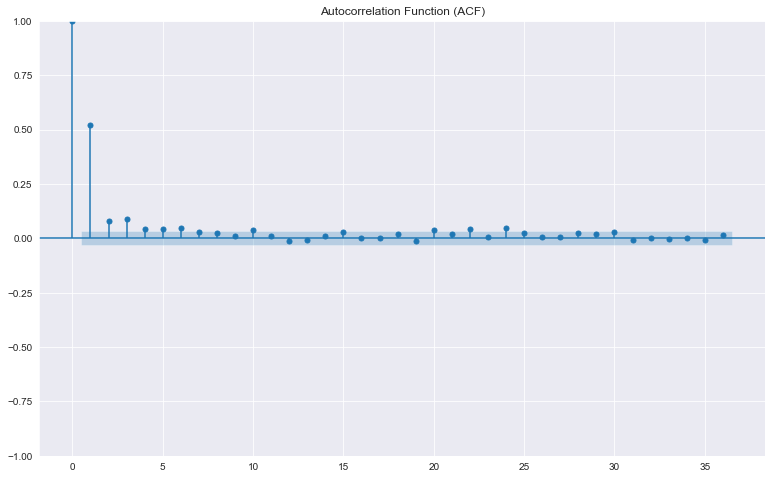

In [233]:
fig, ax = plt.subplots(figsize=(13, 8))
sm.graphics.tsa.plot_pacf(temp_deseasoned,ax)
plt.title('Autocorrelation Function (ACF)')

Też zanika co znaczy możemy skorzystać z modeli ARMA

In [234]:

adf_test = sm.tsa.stattools.adfuller(temp_deseasoned)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Dodatkowo wypiszemy liczbę użytych opóźnień
print('Number of lags used: %d' % adf_test[2])
# oraz liczbę obserwacji
print('Number of observations: %d' % adf_test[3])

ADF Statistic: -8.614382
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Number of lags used: 23
Number of observations: 3619


##### Augmented Dickey-Fuller Test:
Statystyka testowa teraz wynosi $-8,614382$, jest znaczniej mniejsza niż wartości krytyczne, jakie wynoszą $ -3.432, -2.862, -2.567 $ dla $\alpha = \{0.01,0.05,0.1\}$, sugeruje to, że szereg czasowy jest stacjonarny.
P-wartość wynosi $0.00$

Jeszcze raz zobaczymy jak wyglądają teraz dane:

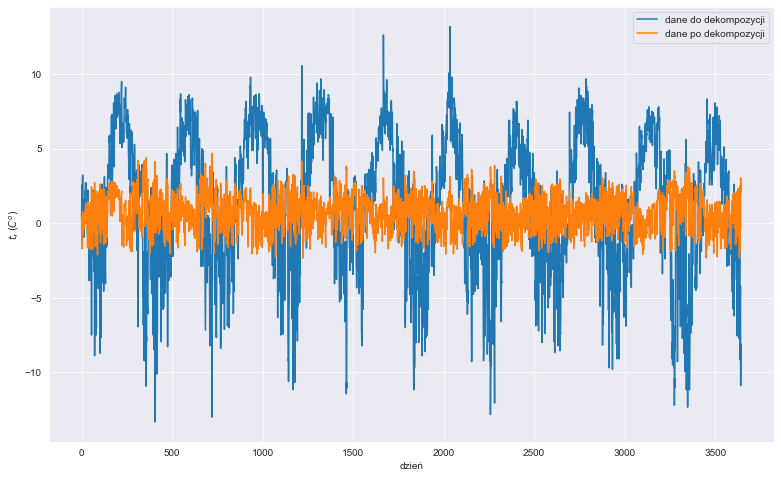

In [235]:
plt.figure(figsize=[13,8])
plt.plot(temperatura, label = 'dane do dekompozycji')
plt.plot(temp_deseasoned, label='dane po dekompozycji')
plt.xlabel("dzień")
plt.ylabel(f"$t, (C^o)$")
plt.legend()
plt.grid(True)


### 3. Modelowanie danych przy pomocy ARMA

#### Dobranie rzędu modelu na podstawie kryterium AIC

Żeby dobrać rzęd modeli skorzystałam z metody siatki (grid search) na podstawie kryterium AIC (Akaike Information Criterion).  
Algorytm z którego korzystałam:
1. Zdefiniowanie zakresu parametrów.
2. Przeszukiwanie przestrzeni parametrów.
3. Obliczenie AIC dla każdego modelu.
4. Wyszukiwanie modeli z najniższym AIC.

Otrzymałam że $p = 2$ oraz $q = 3$, kryterium AIC wyniosł $10143.966652729214$

In [239]:
from statsmodels.tsa.arima.model import ARIMA

# Przykładowe dane szeregu czasowego
data = temp_deseasoned

max_p = 4  # Maksymalna wartość dla p w AR(p)
max_q = 4  # Maksymalna wartość dla q w MA(q)
max_d = 0  # Różnicowanie d=0 dla ARMA

best_aic = np.inf
best_bic = np.inf
best_order = None
best_model = None

for p in range(max_p):
    for q in range(max_q):
        try:
            # Dopasowanie modelu ARIMA z d=0, co jest równoważne ARMA
            temp_model = ARIMA(data, order=(p, max_d, q)).fit()
            
            # Sprawdzenie, czy model ma lepsze AIC niż obecnie najlepszy model
            if temp_model.aic < best_aic:
                best_aic = temp_model.aic
                best_order = (p, q)
                best_model = temp_model
            
            # Sprawdzenie, czy model ma lepsze BIC niż obecnie najlepszy model
            if temp_model.bic < best_bic:
                best_bic = temp_model.bic
            
        except Exception as e:
            print(e)
            continue

print(f'Najlepszy model ARIMA{best_order} z AIC: {best_aic} i BIC: {best_bic}')


c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Najlepszy model ARIMA(2, 3) z AIC: 10143.966652729214 i BIC: 10179.782429860381


c:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Estymacja parametrów modelu 

Dla estymacji parametrów skorzystałam z biblioteki statsmodels.tsa.arima.model w Pythonie. Otrzymałam szereg czasowy z parametrami: $c = 0.7854$, $\phi = \{1.6677, -0.6746\}$, $\theta = \{-1.2099, 0.1482, 0.0932 \}$, $\sigma = 0.9442$

In [240]:

model = ARIMA(temp_deseasoned, order=(2, 0, 3)).fit()

print(model.summary()) #ogólne "podsumowanie" dobranego modelu

coefficients = model.params #wartosci współczynników dobranego modelu (w kolejnosci jak w summary: stała, współczynniki phi, współczynniki theta, sigma^2)

residuals = model.resid #wektor residuów
coefficients, residuals

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3643
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -5064.983
Date:                Wed, 07 Feb 2024   AIC                          10143.967
Time:                        13:29:10   BIC                          10187.371
Sample:                             0   HQIC                         10159.425
                               - 3643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7854      0.077     10.192      0.000       0.634       0.936
ar.L1          1.6677      0.072     23.302      0.000       1.527       1.808
ar.L2         -0.6746      0.068     -9.898      0.0

(array([ 0.78538342,  1.66769238, -0.6745945 , -1.20985805,  0.1482276 ,
         0.09319573,  0.94423386]),
 array([-0.37319549, -1.71367493,  0.13396034, ...,  2.82297663,
         0.63628702,  0.6278105 ]))

### 4. Ocena dopasowania modelu
#### Przedziały ufności dla ACF

Poniżej znajduje się wykres przedziała ufności dla ACF. Można zobaczyć że wszystkie wartości ACF są między liniami. Policzyłam jeszcze procent wartości ACF poza przedziałem ufności dla każdego h, średnie on wyniósł 0.095. 

<function matplotlib.pyplot.legend(*args, **kwargs)>

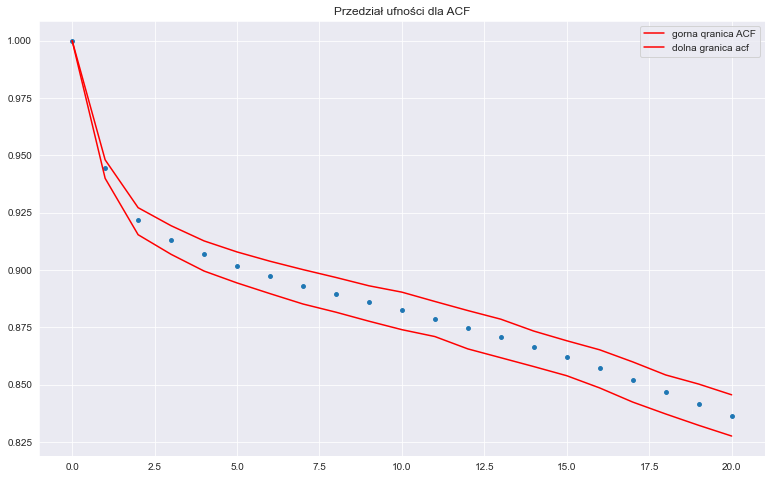

In [245]:
def autocovariation(dane, h):
    dane_mean = np.mean(dane)
    return 1/len(dane)*sum((dane[i-1]- dane_mean)*(dane[i+h-1]-dane_mean) for i in range(1, len(dane)-h+1))

def autocorelation(dane, h):
    return autocovariation(dane, h)/autocovariation(dane, 0)

alpha = 0.05
hs = np.arange(0,21,1)
autokorelacja = [[] for i in hs]
trajektorie =[]
PACF = []
for i in range (100):
    trajektoria = model.simulate(3643) + beta0 +beta1*np.arange(0,3643) -4.54368945 * np.sin(0.01761337*np.arange(0,3643))
    trajektorie.append(trajektoria)
    for h in hs:
        autokorelacja[h].append(autocorelation(trajektoria,h))
        PACF.append(pacf(trajektoria))

PACF = np.transpose(PACF)

gorna_granica_ACF = [np.quantile(data, 1-alpha) for data in autokorelacja]
dolna_granica_ACF = [np.quantile(data, alpha) for data in autokorelacja]
gorna_granica_PACF = [np.quantile(data, 1-alpha) for data in PACF]
dolna_granica_PACF = [np.quantile(data, alpha) for data in PACF]

plt.figure(figsize =(13,8))
plt.plot (hs,gorna_granica_ACF,color = 'red' ,label = 'gorna qranica ACF')
plt.plot (hs,dolna_granica_ACF,c = 'r', label = 'dolna granica acf')
plt.scatter(hs, [np.mean(autokorelacja[h])for h in hs], s=15)
plt.title('Przedział ufności dla ACF')
plt.legend()




#### Przedziały ufności dla PACF

Poniżej znajduje się wykres przedziałow ufności dla ACF. Widać że już nie wszystkie wartoście są pomiędzy liniami. Co potwierdza ten fakt, że procent wartości PACF poza przedziałem ufności jest dużej niż dla ACF, wyniósł on 0.245.

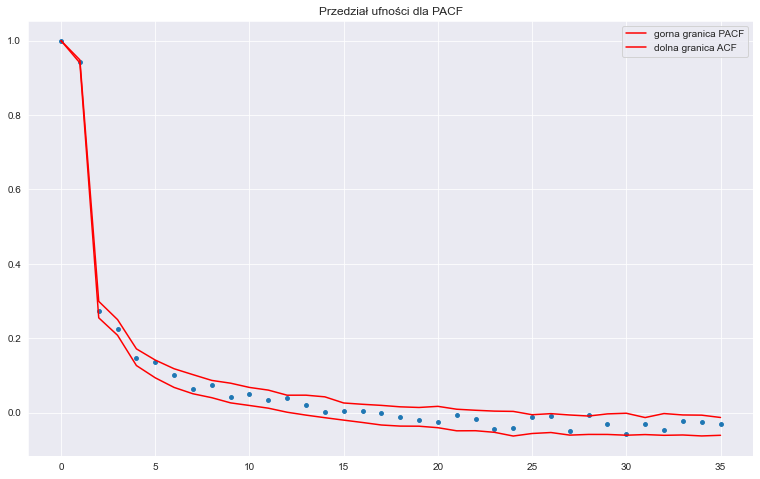

In [246]:
PACF = np.transpose(PACF)
plt.figure(figsize =(13,8))
plt.plot (np.arange(0,36),gorna_granica_PACF,color = 'red' ,label = 'gorna granica PACF')
plt.plot (np.arange(0,36),dolna_granica_PACF,c = 'r', label = 'dolna granica ACF')
plt.scatter(np.arange(0,36), [np.mean([PACF[i][j] for i in range(36)]) for j in range(36)], s = 15)
plt.title('Przedział ufności dla PACF')
plt.legend()

In [247]:
# Liczenie przypadków poza przedziałem ufności dla ACF
liczba_poza_acf = [sum(1 for korelacja in autokorelacja[h] if korelacja < dolna_granica_ACF[h] or korelacja > gorna_granica_ACF[h]) for h in hs]
procent_poza_acf = [liczba / 100.0 for liczba in liczba_poza_acf]  # Zakładamy 100 symulacji

# Liczenie przypadków poza przedziałem ufności dla PACF
liczba_poza_pacf = [sum(1 for korelacja in PACF[j] if korelacja < dolna_granica_PACF[j] or korelacja > gorna_granica_PACF[j]) for j in range(36)]
procent_poza_pacf = [liczba / 100.0 for liczba in liczba_poza_pacf]  # Zakładamy 100 symulacji

# Wydrukuj wyniki
print("Procent wartości ACF poza przedziałem ufności dla każdego h:", np.mean(procent_poza_acf))
print("Procent wartości PACF poza przedziałem ufności dla każdego h:", np.mean(procent_poza_pacf))


Procent wartości ACF poza przedziałem ufności dla każdego h: 0.09523809523809526
Procent wartości PACF poza przedziałem ufności dla każdego h: 0.2508333333333333


#### Prognoza dla przyszłych obserwacji i porównanie z rzeczywistymi danymi

Po korzystaniu z otrzymanego modelu dla prognozy danych temperatury w Jan Mayen w styczniu 2024, otrzymałam taki wykres.


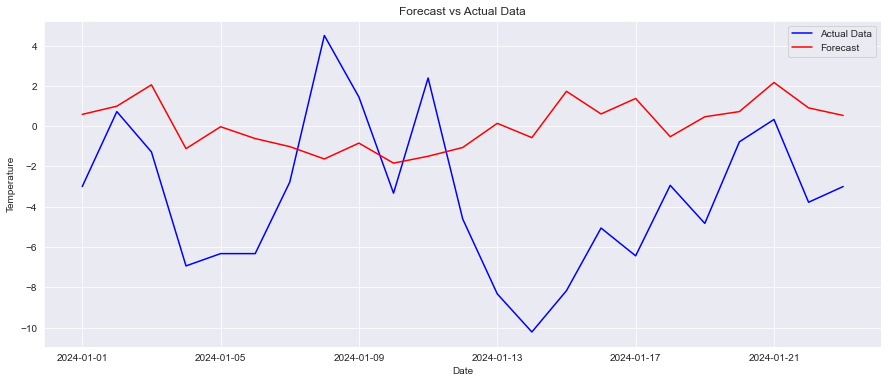

In [248]:
n_forecast = len(temperatura_test)  # Liczba obserwacji do prognozy, taka sama jak liczba obserwacji w zbiorze testowym
'''forecast = model.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean'''
simul = model.simulate(3666)
simull = simul[3643:]

# Przykładowe dane
daty = ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20', '2024-01-21', '2024-01-22', '2024-01-23']

wartosci = simull
df1 = pd.DataFrame({
    'data': daty,
    'wartosc': wartosci
})

df1 = df1.set_index('data')
df1.index = pd.to_datetime(df1.index)


# Porównanie prognoz z rzeczywistymi danymi
actual = df['TEMP'][3643:]
predicted = df1['wartosc']

# Rysowanie wykresu rzeczywistych danych w porównaniu do prognoz
plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Forecast', color='red')
plt.title('Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Widać że model nie idealnie przewiduje przyszłe wartości, ale jest zdolny do uchwycenia dynamiki szeregu czasowego.

### 5. Weryfikacja założeń dotyczących szumu

#### Założenie dot. średniej
Poniżej jest przedstawiony wykres wartości resztowych. Wykres nie pokazuje oczywistych wzorców czy trendów, co jest dobrym znakiem i sugeruje, że model dobrze dopasowuje się do danych. Istnieje jednak pojedyncze, znaczne wypiętrzenie, które może wskazywać na wartość odstającą lub inny problem w danych, który nie został uwzględniony w modelu.

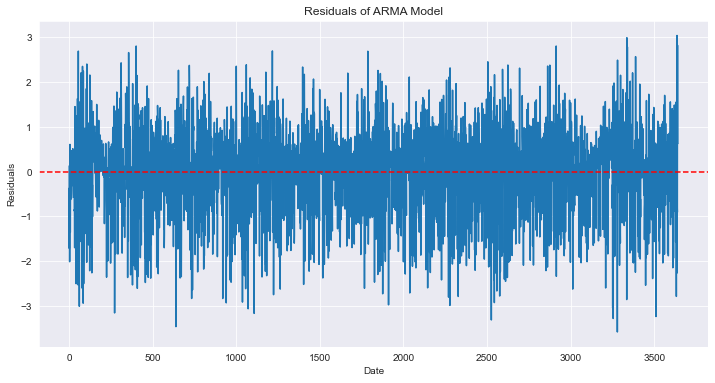

In [ ]:
#(wykres wartości resztowych
residuals = model.resid

# Rysowanie wykresu reszt
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

##### Wyniki testu t:
t-statistic: -0.007734570314583497
p-value: 0.9938292379486273

Wartość statystyki testowej jest bardzo bliska zeru, co sugeruje, że średnia reszt jest bliska zeru.
Wartość p jest znacznie wyższa niż standardowy poziom istotności (zazwyczaj 0.05), co oznacza, że nie ma podstaw do odrzucenia hipotezy zerowej mówiącej o braku różnicy między średnią reszt a zerem.

#### Założenie dot. wariancji

#### Wyniki testu Levene'a:

Levene Test Statistic: 7.1463475333135715
p-value: 0.007548926471167769

Statystyka testu Levene'a jest stosunkowo wysoka. Wartość p jest poniżej 0.10, co może wskazywać na to, że wariancje są nierówne (heteroskedastyczność), jednak wartość p jest wyższa niż standardowy próg 0.05, więc wynik ten może być na granicy istotności statystycznej.

### Założenie dotyczące niezależności

Wykresy ACF oraz PACF dla wartości resztowych: widać, że wszystkie słupki ACF mieszczą się wewnątrz pasm ufności, co wskazuje na to, że nie ma istotnej autokorelacji na żadnym z opóźnień. Jest to dobra oznaka i wskazuje na to, że reszty są bliskie niezależności. Na wykresie PACF widać, że wszystkie słupki mieszczą się wewnątrz pasm ufności, co sugeruje brak istotnej częściowej autokorelacji w resztach modelu. To również jest zgodne z oczekiwaniem, że reszty są niezależne.

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


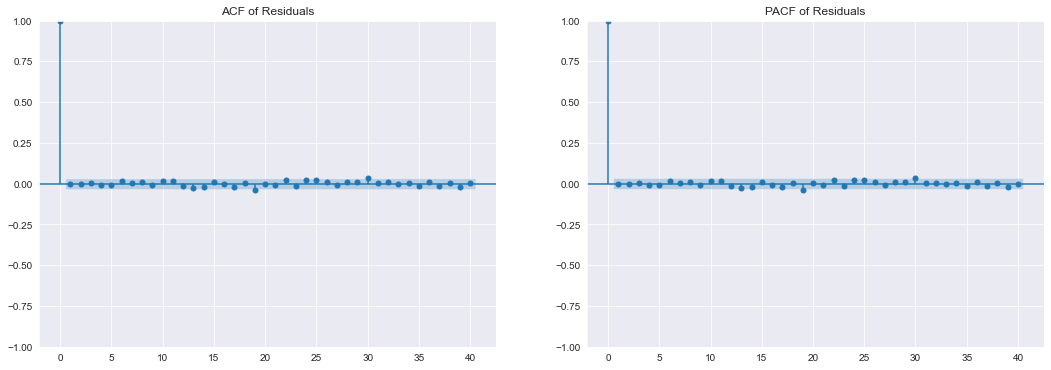

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Rysowanie wykresów ACF i PACF
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

plot_acf(residuals, ax=ax[0], lags=40, alpha=0.05)
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1], lags=40, alpha=0.05)
ax[1].set_title('PACF of Residuals')

plt.show()

### Założenie dotyczące normalności rozkładu

##### Wyniki testu Shapiro-Wilka:

Shapiro-Wilka Test: Statistics=0.984, p=0.000

Wartość statystyki testu Shapiro-Wilka, jest bliska 1, sugerując, że dane mogą mieć rozkład bliski normalnemu.

p-wartość wskazuje na to, że hipoteza zerowa o normalności rozkładu została odrzucona na znaczącym poziomie istotności. Prawdopodobnie ze względu na dużą liczbę próbek nawet niewielkie odchylenia od normalności mogą prowadzić do odrzucenia hipotezy o normalności.

C:\Users\negul\AppData\Local\Temp\ipykernel_21588\137699103.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, fit=norm, kde=True, hist=True)


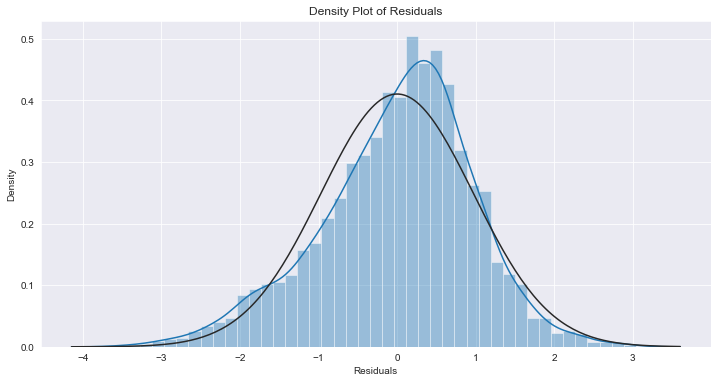

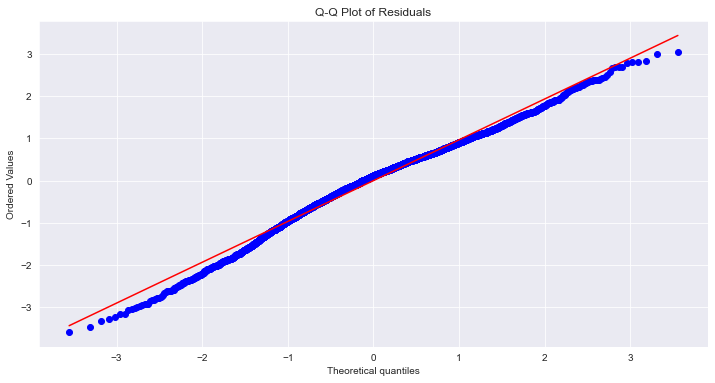

Shapiro-Wilka Test: Statistics=0.987, p=0.000
D'Agostino's K-squared Test: Statistics=109.152, p=0.000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
#from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from scipy.stats import levene
#from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy.stats import norm
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import probplot


# Wykres gęstości
plt.figure(figsize=(12, 6))
sns.distplot(residuals, fit=norm, kde=True, hist=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Wykres kwantylowy
plt.figure(figsize=(12, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Test Shapiro-Wilka
stat, p = shapiro(residuals)
print('Shapiro-Wilka Test: Statistics=%.3f, p=%.3f' % (stat, p))

# Test D'Agostino's K-squared
stat, p = normaltest(residuals)
print("D'Agostino's K-squared Test: Statistics=%.3f, p=%.3f" % (stat, p))

In [3]:
(0.999)**1000

0.36769542477096373

Na podstawie wykresu gęstości, reszty wydają się mieć kształt zbliżony do normalnego, ale ze względu na wyniki testów statystycznych, mogą występować pewne odchylenia od normalności.

Na podstawie wykresu kwantylowego, większość punktów leży blisko linii, ale widoczne są odstępstwa na końcach rozkładu, co wskazuje na obecność "ciężkich ogonów" - więcej ekstremalnych wartości niż oczekuje się w przypadku normalnego rozkładu.

### 6. Wnioski


Podsumowując przeprowadzoną analizę, model ARMA wydaje się być skutecznym narzędziem do modelowania i analizy wybranego szeregu czasowego. Na podstawie uzyskanych wyników, wykresów oraz przeprowadzonych testów statystycznych, możemy sformułować następujące wnioski:

1. Udało się z powodzeniem zastosować model ARMA do analizy szeregów czasowych, co wskazuje na adekwatność tego modelu do charakterystyki danych. Dobra zdolność przewidywania przyszłych wartości potwierdza, że model dobrze uchwycił zależności w danych historycznych.

2. Proces dopasowania modelu, w tym wybór odpowiednich rzędów autoregresji (AR) i średniej ruchomej (MA), został przeprowadzony efektywnie. Odpowiednia konfiguracja parametrów jest kluczowa dla osiągnięcia wiarygodnych prognoz i wskazuje na dokładną analizę właściwości danych oraz kompetencje w zakresie modelowania statystycznego.

3. Dobre wyniki prognozowania przez model ARMA podkreślają jego przydatność w planowaniu i podejmowaniu decyzji. 

4. Dopasowanie Modelu: Model ARMA został z powodzeniem dopasowany do danych, co wskazują analizy reszt. Brak wyraźnych wzorców na wykresach ACF i PACF reszt sugeruje, że model skutecznie wyłapał informacje z danych szeregu czasowego. Reszty wydają się być niezależne, co jest kluczowym założeniem w efektywnym modelowaniu szeregów czasowych.

5. Analiza Reszt: Analiza reszt wskazała na brak istotnych autokorelacji, zarówno na podstawie ACF, jak i PACF, co sugeruje dobrą specyfikację modelu. Jednakże, wykryto potencjalne odchylenia od normalności rozkładu, co może wskazywać na konieczność dalszej optymalizacji modelu lub zastosowania alternatywnych podejść do modelowania reszt, które lepiej radzą sobie z ewentualnymi nieregularnościami.

6. Testy na Normalność: Wyniki testów Shapiro-Wilka wskazują na odrzucenie hipotezy o normalności rozkładu reszt. To może sugerować, że warto rozważyć transformacje danych lub zastosowanie bardziej zaawansowanych modeli, takich jak ARMA z niestandardowymi rozkładami reszt.

Dobrze dopasowany model ARMA może stanowić podstawę do dalszych badań i eksploracji innych modeli szeregów czasowych, takich jak ARIMA, SARIMA czy nawet bardziej zaawansowane metody oparte na uczeniu maszynowym. Może to prowadzić do jeszcze lepszego zrozumienia danych i dalszego zwiększenia dokładności prognoz.

Podsumowując, skuteczne dopasowanie modelu ARMA i generowanie przez niego dobrych prognoz to znaczący sukces, który otwiera możliwości wykorzystania tych technik w praktycznych zastosowaniach oraz zachęca do dalszego pogłębiania wiedzy i umiejętności w dziedzinie modelowania szeregów czasowych.

